In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

2024-01-10 14:00:11.884971: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 14:00:11.915286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 14:00:11.915340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 14:00:11.917057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 14:00:11.923072: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 14:00:11.923653: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
data = pd.read_csv("/home/lumimox/Algo_trading/Dataset/Satatinoary_data.csv")

In [9]:
data.head(10)

,Date,Open,High,Low,Close,Adj Close
0,2018-01-02,-487.200195,1332.399414,8.899414,1324.899414,1324.899414
1,2018-01-03,1353.200195,128.200196,1680.900391,218.900391,218.900391
2,2018-01-04,292.500000,166.900390,-322.299805,398.200195,398.200195
3,2018-01-05,206.500000,1965.499024,680.599610,1830.299805,1830.299805
4,2018-01-06,1984.899414,7.201172,1561.799804,97.500000,97.500000
5,2018-01-07,65.201172,-132.800782,-676.899414,-1049.400391,-1049.400391
6,2018-01-08,-1051.101562,-1041.699218,-1879.500000,-1307.500000,-1307.500000
7,2018-01-09,-1352.499024,-1040.400391,215.799805,-574.699218,-574.699218
8,2018-01-10,-535.200195,-524.200195,-732.799805,377.899414,377.899414
9,2018-01-11,379.700195,45.500000,-585.299804,-1567.500000,-1567.500000


In [4]:
# Determine the sizes for train, validation, and test sets
train_size = int(0.6 * len(data))  # 60% for training
val_size = int(0.2 * len(data))    # 20% for validation
test_size = len(data) - train_size - val_size  # Remaining for testing

# Split the data into train, validation, and test sets
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

Epoch 1/50
37/37 [==============================] - 2s 4ms/step - loss: 0.0321
Epoch 2/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 3/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 5/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 6/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 7/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 8/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 9/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 10/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 11/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 12/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 13/50
37/37 [==============================

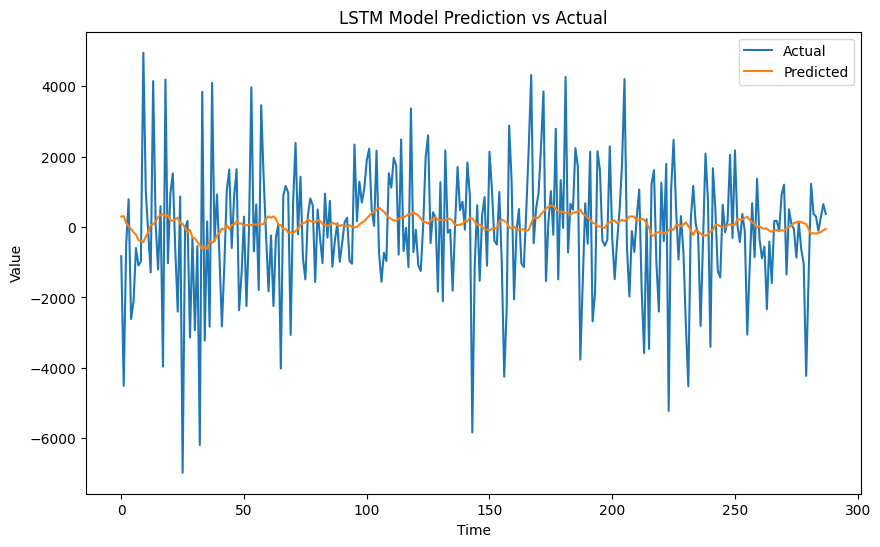

In [8]:
import joblib

# Data preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Open'].values.reshape(-1, 1))

# Splitting data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create dataset with time steps
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        a = data[i:(i + time_steps), 0]
        X.append(a)
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Setting time steps and creating train and test datasets
time_steps = 10
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshaping input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Creating LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Save the trained model
model.save("lstm_model.keras")
print("Model saved successfully.")

# Save the MinMaxScaler
joblib.dump(scaler, 'min_max_scaler.pkl')
print("Scaler saved successfully.")

# Predicting on test data
predicted_values = model.predict(X_test)

# Inverse transform predictions to original scale
predicted_values = scaler.inverse_transform(predicted_values)

# Inverse transform actual test values to original scale for evaluation
y_test = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test)

# Calculating RMSE for evaluation
rmse = np.sqrt(mean_squared_error(y_test, predicted_values))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Visualizing predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predicted_values, label='Predicted')
plt.title('LSTM Model Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [7]:
X_train[0]

array([[0.45470186],
       [0.58360616],
       [0.50931319],
       [0.50328962],
       [0.62785128],
       [0.49339285],
       [0.4152054 ],
       [0.39409508],
       [0.45133987],
       [0.51542081]])

Model loaded successfully.
Scaler loaded successfully.


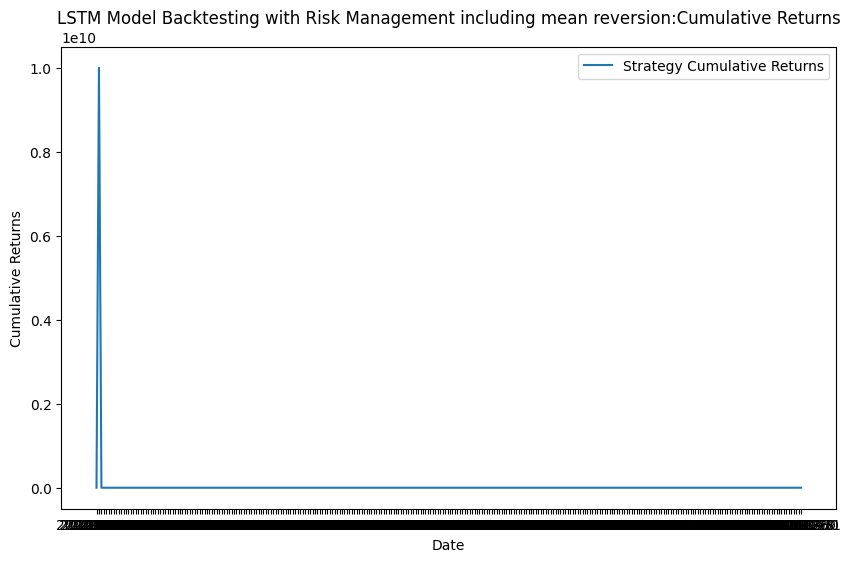

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error

# Assuming 'data' DataFrame has the original data with the 'Date' column
# Assuming 'predicted_values' and 'y_test' have the predicted and actual values

# Load the trained LSTM model
model = load_model("lstm_model.keras")
print("Model loaded successfully.")

# Load the MinMaxScaler
scaler = joblib.load('min_max_scaler.pkl')
print("Scaler loaded successfully.")

# Create a DataFrame for the predicted values with the corresponding dates
predicted_df = pd.DataFrame(data={'Date': data['Date'].iloc[-len(predicted_values):].values,
                                  'Predicted': predicted_values.flatten()})

# Merge the predicted values with the actual values on the 'Date' column
merged_df = pd.merge(predicted_df, data, on='Date', how='inner')

# Calculate the historical average
window_size = 20  # You can adjust this parameter
merged_df['Rolling_Mean'] = merged_df['Close'].rolling(window=window_size).mean()

# Define a threshold for mean reversion (you can adjust this)
reversion_threshold = 0.02

# Generate mean reversion signals
merged_df['Mean_Reversion_Signal'] = 0
merged_df.loc[window_size:, 'Mean_Reversion_Signal'] = np.where(
    (merged_df['Close'][window_size:] < merged_df['Rolling_Mean'][window_size:] * (1 - reversion_threshold)) |
    (merged_df['Close'][window_size:] > merged_df['Rolling_Mean'][window_size:] * (1 + reversion_threshold)),
    1,
    0
)

# Signal generation based on predicted values
merged_df['Signal'] = np.where(merged_df['Predicted'] > merged_df['Open'], 1, -1)

# Assuming initial capital and risk per trade
initial_capital = 100000  # Example: $100,000
risk_per_trade = 0.02  # Example: 2%

# Calculate position size based on risk per trade
merged_df['Position_Size'] = initial_capital * risk_per_trade / merged_df['Open']

# Limit the position size to a maximum percentage of the initial capital
max_position_size_percent = 0.05  # Example: 5%
merged_df['Position_Size'] = np.minimum(merged_df['Position_Size'], initial_capital * max_position_size_percent)

# Assuming a stop-loss and take-profit percentage
stop_loss_percent = 0.02  # Example: 2%
take_profit_percent = 0.03  # Example: 3%

# Calculate stop-loss and take-profit levels
merged_df['Stop_Loss'] = merged_df['Open'] * (1 - stop_loss_percent)
merged_df['Take_Profit'] = merged_df['Open'] * (1 + take_profit_percent)

# Initialize positions and capital
merged_df['Position'] = 0.0  # Initialize 'Position' column with a float
merged_df['Capital'] = 0.0  # Initialize 'Capital' column with a float

# Simulate trading based on signals and risk management
for i in range(1, len(merged_df)):
    # Execute buy order
    if merged_df['Signal'][i] == 1:
        merged_df.loc[i, 'Position'] = float(merged_df['Position_Size'][i])
        merged_df.loc[i, 'Capital'] = float(merged_df.loc[i, 'Position'] * merged_df.loc[i, 'Open'] + merged_df.loc[i - 1, 'Capital'])

    # Execute sell order
    elif merged_df['Signal'][i] == -1:
        merged_df.loc[i, 'Position'] = float(-merged_df['Position_Size'][i])
        merged_df.loc[i, 'Capital'] = float(merged_df.loc[i, 'Position'] * merged_df.loc[i, 'Open'] + merged_df.loc[i - 1, 'Capital'])

    # Hold position
    else:
        merged_df.loc[i, 'Position'] = float(merged_df.loc[i - 1, 'Position'])
        merged_df.loc[i, 'Capital'] = float(merged_df.loc[i, 'Position'] * merged_df.loc[i, 'Open'] + merged_df.loc[i - 1, 'Capital'])

# Calculate daily returns based on capital changes
merged_df['Daily_Return'] = merged_df['Capital'].pct_change()

# Replace NaN values with 0
merged_df['Daily_Return'].fillna(0, inplace=True)

# Replace infinity values with a large number (e.g., 1e10)
merged_df['Daily_Return'].replace([np.inf, -np.inf], 1e10, inplace=True)

# Cumulative returns
merged_df['Cumulative_Return'] = (1 + merged_df['Daily_Return']).cumprod()

# Plotting cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], merged_df['Cumulative_Return'], label='Strategy Cumulative Returns')
plt.title('LSTM Model Backtesting with Risk Management including mean reversion:Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()